# DistilBERT

On utilise le modèle DistilBERT de la library HuggingFace. 

In [69]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import  GridSpec

## Preprocessing 
On la nettoie rapidement des valeurs manquantes, on nettoie le texte (on décontracte les contractions, on enlève les symboles ...)

In [5]:
df = pd.read_csv("ManifestoUK2.csv", encoding = "latin1")
df = df.drop(columns = ["Unnamed: 0", "eu_code","pos"])

#Nous enlevons les NaN et les cmp_code dont la valeur est H
df = df[df["cmp_code"] == df["cmp_code"]]
df = df[df["cmp_code"] != "H"]
df = df[df["cmp_code"] != '000'].reset_index(drop = True)

# Nous enlevons les cmp_code qui ne sont pas des strings
index = []

for i in range(np.shape(df)[0]):
    if type(df["text"][i]) != str:
        index.append(i)
        
df = df.drop(index).reset_index(drop = True)
df['category_1'] = df["cmp_code"].apply(lambda x: int(x[0]))

# nombre de classes
nb_lab = len(df.category_1.unique())

# On nettoie un peu le texte avant d'implémenter le model
from bs4 import BeautifulSoup
import unicodedata
import re 

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"its", "it is", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def pre_process_document(document):
    document = document.lower()
    document = remove_accented_chars(document)   
    document = decontracted(document)     
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  
    document = re.sub(' +', ' ', document)
    document = document.strip()
    return document

pre_process_corpus = np.vectorize(pre_process_document)

df['text'] = pre_process_corpus(df.text)

## Tokenization avec DistilBERT

Nous commençons par déterminer la longueur maximale des phrases du texte, ce qui est nécessaire afin de tokenizer avec DistilBERT. Chaque embedding a une taille fixe, celle correspondant à la phrase la plus longue de la base. 

In [6]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)

sentences = df.text.values
labels_init = df.category_1.values
#On fait démarer les classes à 0 dans le modèle (on a 7 classes de 0 à 6)
labels_init = labels_init-1

max_len = 0
for sent in sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    

print('Max sentence length: ', max_len)

Max sentence length:  119


Nous tokenisons, et nous récupérons deux vecteurs: les inputs_ids (les embeddings) et les attention_masks (utile pour comprendre quels sont les embeddings qui sont nécessaires pour comprendre le sens de la phrase).

In [7]:
input_ids = []
attention_masks = []
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

In [8]:
l_init = labels_init.tolist()
labels_init_tensor = torch.tensor(l_init)

ii = []
for j in range(len(input_ids)):
    ii.append(input_ids[j].tolist()[0])
    
input_ids_tensor = torch.tensor(ii)

aa = []
for j in range(len(attention_masks)):
    aa.append(attention_masks[j].tolist()[0])
    
attention_masks_tensor = torch.tensor(aa)

In [9]:
input_ids_tensor = input_ids_tensor.numpy()
labels_init_tensor = labels_init_tensor.numpy()
attention_masks_tensor = attention_masks_tensor.numpy()

In [11]:
input_ids_list=[]
for i in range(len(input_ids)):
    input_ids_list.append(input_ids[i].tolist()[0])

In [12]:
df['embeddings'] = input_ids_list
df

,text,cmp_code,category_1,embeddings
0,we face three connected crises healing the pla...,416,4,"[101, 2057, 2227, 2093, 4198, 25332, 8907, 199..."
1,creating a more equal society reversing the tr...,503,5,"[101, 4526, 1037, 2062, 5020, 2554, 7065, 2545..."
2,creating truly democratic central and local go...,202,2,"[101, 4526, 5621, 3537, 2430, 1998, 2334, 2231..."
3,to help heal the planet we will make achieving...,501,5,"[101, 2000, 2393, 11005, 1996, 4774, 2057, 209..."
4,invest in an billion public programme of renew...,501,5,"[101, 15697, 1999, 2019, 4551, 2270, 4746, 199..."
...,...,...,...,...
21662,ukip will end the use of council procurement c...,303,3,"[101, 2866, 11514, 2097, 2203, 1996, 2224, 199..."
21663,staff should stick within agreed budgets,303,3,"[101, 3095, 2323, 6293, 2306, 3530, 26178, 102..."
21664,ukip will review the many statutory duties pla...,303,3,"[101, 2866, 11514, 2097, 3319, 1996, 2116, 152..."
21665,councils should only be doing what they do bes...,303,3,"[101, 10784, 2323, 2069, 2022, 2725, 2054, 202..."


## Séparation Train / Test

In [13]:
from sklearn.model_selection import train_test_split
train_size = int(0.9 * len(df))
val_size = len(df) - train_size

inputs_train, inputs_test, labels_train, labels_test, attention_masks_train, attention_masks_test = train_test_split(input_ids_tensor, labels_init_tensor, attention_masks_tensor, test_size = val_size, random_state = 42)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

19,500 training samples
2,167 validation samples


In [14]:
print(inputs_train[0])
print(labels_train[0])
print(attention_masks_train[0])

[  101  2008  2003  2339  1996  4104  2231  2405 12014 10340  2008  2052
  2562  3885  1999  1996  2309  3006  2130  2004  2057  2187  1996  7327
   102     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0]
0
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Implémentation de DistilBertForSequenceClassification

In [10]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = nb_lab)

In [15]:
inputs_train, inputs_test, labels_train, labels_test, attention_masks_train, attention_masks_test = torch.tensor(inputs_train), torch.tensor(inputs_test), torch.tensor(labels_train), torch.tensor(labels_test), torch.tensor(attention_masks_train), torch.tensor(attention_masks_test)

On créer un torch DataLoader (un itérateur) pour notre base de données, afin d'économiser de la mémoire pendant le training

In [87]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32 

train_data = TensorDataset(inputs_train, attention_masks_train, labels_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(inputs_test, attention_masks_test, labels_test)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [20]:
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

lr = 2e-5
max_grad_norm = 1.0
num_total_steps = 1000
num_warmup_steps = 100
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  # 0.1


optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)  
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = num_warmup_steps, 
                                            num_training_steps = num_total_steps)

On fine-tune ce modèle pour une époque car le temps d'éxécution est trop long 

In [96]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


import random
import numpy as np
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
total_t0 = time.time()
epochs = 1

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]
        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)    
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        total_eval_loss += loss.item()
        logits = logits.detach().numpy()
        label_ids = b_labels.numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

torch.save(model.state_dict(),'model1.h5')


======== Epoch 1 / 1 ========
Training...
  Batch    50  of  1,219.    Elapsed: 0:06:42.
  Batch   100  of  1,219.    Elapsed: 0:13:08.
  Batch   150  of  1,219.    Elapsed: 0:19:33.
  Batch   200  of  1,219.    Elapsed: 0:27:34.
  Batch   250  of  1,219.    Elapsed: 0:34:42.
  Batch   300  of  1,219.    Elapsed: 0:42:04.
  Batch   350  of  1,219.    Elapsed: 0:49:44.
  Batch   400  of  1,219.    Elapsed: 0:57:07.
  Batch   450  of  1,219.    Elapsed: 1:04:32.
  Batch   500  of  1,219.    Elapsed: 1:11:53.
  Batch   550  of  1,219.    Elapsed: 1:20:08.
  Batch   600  of  1,219.    Elapsed: 1:27:39.
  Batch   650  of  1,219.    Elapsed: 1:34:13.
  Batch   700  of  1,219.    Elapsed: 1:41:04.
  Batch   750  of  1,219.    Elapsed: 1:48:22.
  Batch   800  of  1,219.    Elapsed: 1:55:49.
  Batch   850  of  1,219.    Elapsed: 2:03:24.
  Batch   900  of  1,219.    Elapsed: 2:11:44.
  Batch   950  of  1,219.    Elapsed: 2:19:59.
  Batch 1,000  of  1,219.    Elapsed: 2:28:20.
  Batch 1,050  of

In [29]:
torch.save(model,'model1bis.h5')
MODEL = torch.load('model1bis.h5')

In [16]:
MODEL = torch.load('model1bis.h5')

## Analyses des erreurs et des performances du modèle

In [17]:
#Le modèle nous renvoie des probabilités pour chaque classe
#Le label prédit est donc celui ayant la plus grande probabilité

with torch.no_grad():
    last_hidden_states = MODEL(inputs_test,attention_mask = attention_masks_test)
logits = last_hidden_states[0].numpy()

In [19]:
log_probs = tf.nn.log_softmax(logits, axis=-1) 
probs = np.exp(log_probs)

In [20]:
probs = probs.tolist()
labels_pred = []
labels_pred_scd = [] # On récupère la seconde plus grande probabilité 
valeur_prob=[]   # On récupère les valeurs des probabilités
valeur_scd_prob = [] 
for i in range(len(probs)):
    p=probs[i]
    ind=p.index(max(p))
    labels_pred.append(ind)
    valeur_prob.append(max(p))
    p[ind]=0
    labels_pred_scd.append(p.index(max(p)))
    valeur_scd_prob.append(max(p))
    

In [21]:
# On recupère les phrases de la base test à partir de leur embeddings
L = list(df['embeddings'])
M = inputs_test.tolist()
sentences_test=[]
index_test=[]
for i in range(len(M)):
    index_test.append(L.index(M[i]))
for j in index_test:
    sentences_test.append(df.text[j])

In [22]:
y_pred = labels_pred
scd_y_pred = labels_pred_scd
y_true = []
for i in index_test:
    y_true.append(df.category_1[i]-1)

In [24]:
# On crée une base test
base_test = pd.DataFrame({'text': sentences_test,'embedding':inputs_test.tolist(), 'y_true': y_true, 'y_pred': y_pred,'scd_y_pred':labels_pred_scd,'valeur_prob_pred':valeur_prob,'valeur_scd_prob_pred':valeur_scd_prob})

In [25]:
base_test

,text,embedding,y_true,y_pred,scd_y_pred,valeur_prob_pred,valeur_scd_prob_pred
0,with vision commitment and determination we co...,"[101, 2007, 4432, 8426, 1998, 9128, 2057, 2071...",5,5,4,0.623361,0.252469
1,we will deliver on our commitment to improve n...,"[101, 2057, 2097, 8116, 2006, 2256, 8426, 2000...",4,4,3,0.926159,0.042219
2,we were the first country to introduce a clima...,"[101, 2057, 2020, 1996, 2034, 2406, 2000, 8970...",4,4,3,0.949521,0.025769
3,we will press for comprehensive and understand...,"[101, 2057, 2097, 2811, 2005, 7721, 1998, 3305...",4,0,4,0.546814,0.256997
4,the length of this phased programme will be pl...,"[101, 1996, 3091, 1997, 2023, 21718, 4746, 209...",4,4,3,0.492178,0.468349
...,...,...,...,...,...,...,...
2162,poor information complex pricing and exploitat...,"[101, 3532, 2592, 3375, 20874, 1998, 18077, 80...",3,3,4,0.933326,0.017526
2163,recognise fully the housing needs of people wh...,"[101, 17614, 3929, 1996, 3847, 3791, 1997, 211...",4,4,6,0.910138,0.056337
2164,an independent commission should be establishe...,"[101, 2019, 2981, 3222, 2323, 2022, 2511, 2000...",2,2,4,0.301513,0.287767
2165,but burning fossil fuels for energy causes cli...,"[101, 2021, 5255, 10725, 20145, 2005, 2943, 53...",4,4,3,0.939200,0.039680


In [26]:
#On vérifie que l'accuracy calculée est bonne sur la base test
c = 0
for i in range(len(base_test)):
    if base_test.y_true[i]==base_test.y_pred[i]:
        c+=1

print('L\'accuracy sur la base test est:' +str(c/len(base_test)))

L'accuracy sur la base test est :0.6691278264882325


In [27]:
# Nous recensons les erreurs commises
index_err=[]
emb_err=[]
text_err=[]
proba_err=[]
for i in range(len(base_test)):
    if base_test.y_true[i]!=base_test.y_pred[i]:
        index_err.append(i)
        emb_err.append(base_test.embedding[i])
        text_err.append(base_test.text[i])
        proba_err.append(base_test.valeur_prob_pred[i])

nb_err= len(index_err)

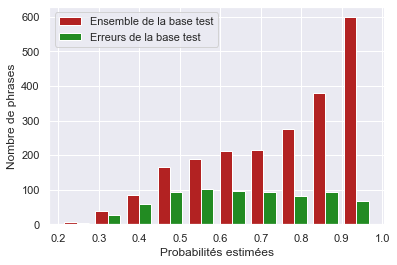

In [73]:
# Nous nous intéressons aux valeurs des probabilités renvoyé par le modèle, pour les labels prédits
bins = 10
plt.hist([base_test.valeur_prob_pred.values, proba_err], bins = bins, color = ['Firebrick', 'forestgreen'],
            label = ['Ensemble de la base test', 'Erreurs de la base test '],
            histtype = 'bar') # bar est le defaut
#plt.ylabel('nombres')
plt.xlabel('Probabilités estimées')
plt.ylabel('Nombre de phrases')
plt.legend()
plt.grid(True)
plt.savefig("Repartition_des_probas.pdf")

Nous avons essayé de voir si la valeur de la probabilité du label prédit renvoyé par le modèle pouvait nous dire quelque chose sur la fiabilité du résultat. On voit sur graphique que lorsque l'on a une probabilité de 0.3 ou 0.4, on a de forte chance que le modèle se soit trompé de labels. En revanche, on voit que quelques soit la valeur de la probabilité, le modèle a des chances de se tromper. On ne peut pas vraiment identifier de règle quand à la véracité du label prédit compte tenu de la probabilité renvoyé par le modèle. 

Intéréssons nous aux secondes plus grandes valeurs des probabilités renvoyé par le modèle, lorsque le label prédit par le modèle est faux.

In [29]:
# On recense les erreurs comises lorsqu'on considère les deuxièmes plus grande probabilités, dans les cas ou le modèle ne 
# prédit pas le bon label
cbis=0
ind_scd_err_faux=[]
ind_scd_err_vrai=[]
for i in range(len(base_test)):
    if base_test.y_true[i]!=base_test.y_pred[i]:
        if base_test.scd_y_pred[i]==base_test.y_true[i]:
            cbis+=1
            ind_scd_err_vrai.append(i)
        else:
            ind_scd_err_faux.append(i)
        
print('Lorsque le prédicteur ne prédit pas le bon label (ie lorsque la plus grande probabilité renvoyé par le modèle ne correspond pas au vrai label), il ne se trompe pas en considérant la seconde plus grande proba avec un taux de:' +str(cbis/nb_err))

Lorsque le prédicteur ne prédit pas le bon label (ie lorsque la plus grande probabilité renvoyé par le modèle ne correspond pas au vrai label), il ne se trompe pas en considérant la seconde plus grande proba avec un taux de  :0.5801952580195258


In [30]:
acc_2_proba = 0
for i in range(len(base_test)):
    if base_test.y_pred[i] == base_test.y_true[i]:
        acc_2_proba+=1
    else:
        if base_test.scd_y_pred[i] == base_test.y_true[i]:
            acc_2_proba+=1


print('L\'accuracy sur la base test en considerant les deux plus grandes proba est:' +str(acc_2_proba/len(base_test)))

L'accuracy sur la base test en considerant les deux plus grandes proba est :0.8610982925703737


On s'intérèsse maintenant aux répartitions des erreurs comises

In [31]:
prop_classe_mal_pred = {'0':0, '1':0, '2':0, '3':0, '4':0,'5':0,'6':0}
prop_classe = {'0':0, '1':0, '2':0, '3':0, '4':0,'5':0,'6':0}

for i in range(len(base_test)):
    if base_test.y_true[i]!=base_test.y_pred[i]:
        prop_classe_mal_pred[str(base_test.y_true[i])]+=1
        
for i in range(len(base_test)):
        prop_classe[str(base_test.y_true[i])]+=1

prop = {'0':0, '1':0, '2':0, '3':0, '4':0,'5':0,'6':0}
for i in range(7):
    prop[str(i)] = round(prop_classe_mal_pred[str(i)]/prop_classe[str(i)],2)

In [32]:
prop_vrai_lab = {'1':prop['0'], '2':prop['1'], '3':prop['2'], '4':prop['3'], '5':prop['4'],'6':prop['5'],'7':prop['6']}

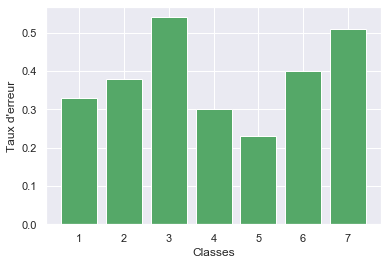

In [74]:
plt.xlabel('Classes')
plt.ylabel('Taux d\'erreur')
plt.bar(prop_vrai_lab.keys(), prop.values(), color='g')
plt.grid(True)
plt.savefig("prop_err_par_classe.pdf")

On voit que la modèle se trompe presque 1 fois sur 2 lorsqu'il doit prédir la classe 3 ou 7. C'est avec la classe 5 qu'il se trompe le moins.

Pour chaque classe, on regarde ce que le modèle prédit lorsqu'il se trompe

In [34]:
prop0 = {'1':0, '2':0, '3':0, '4':0, '5':0,'6':0,'7':0}
prop1 = {'1':0, '2':0, '3':0, '4':0, '5':0,'6':0,'7':0}
prop2 = {'1':0, '2':0, '3':0, '4':0, '5':0,'6':0,'7':0}
prop3 = {'1':0, '2':0, '3':0, '4':0, '5':0,'6':0,'7':0}
prop4 = {'1':0, '2':0, '3':0, '4':0, '5':0,'6':0,'7':0}
prop5 = {'1':0, '2':0, '3':0, '4':0, '5':0,'6':0,'7':0}
prop6 = {'1':0, '2':0, '3':0, '4':0, '5':0,'6':0,'7':0}
L = [prop0,prop1,prop2,prop3,prop4,prop5,prop6]
for i in range(len(base_test)):
    if base_test.y_true[i]!=base_test.y_pred[i]:
        L[base_test.y_true[i]][str(base_test.y_pred[i]+1)]+=1

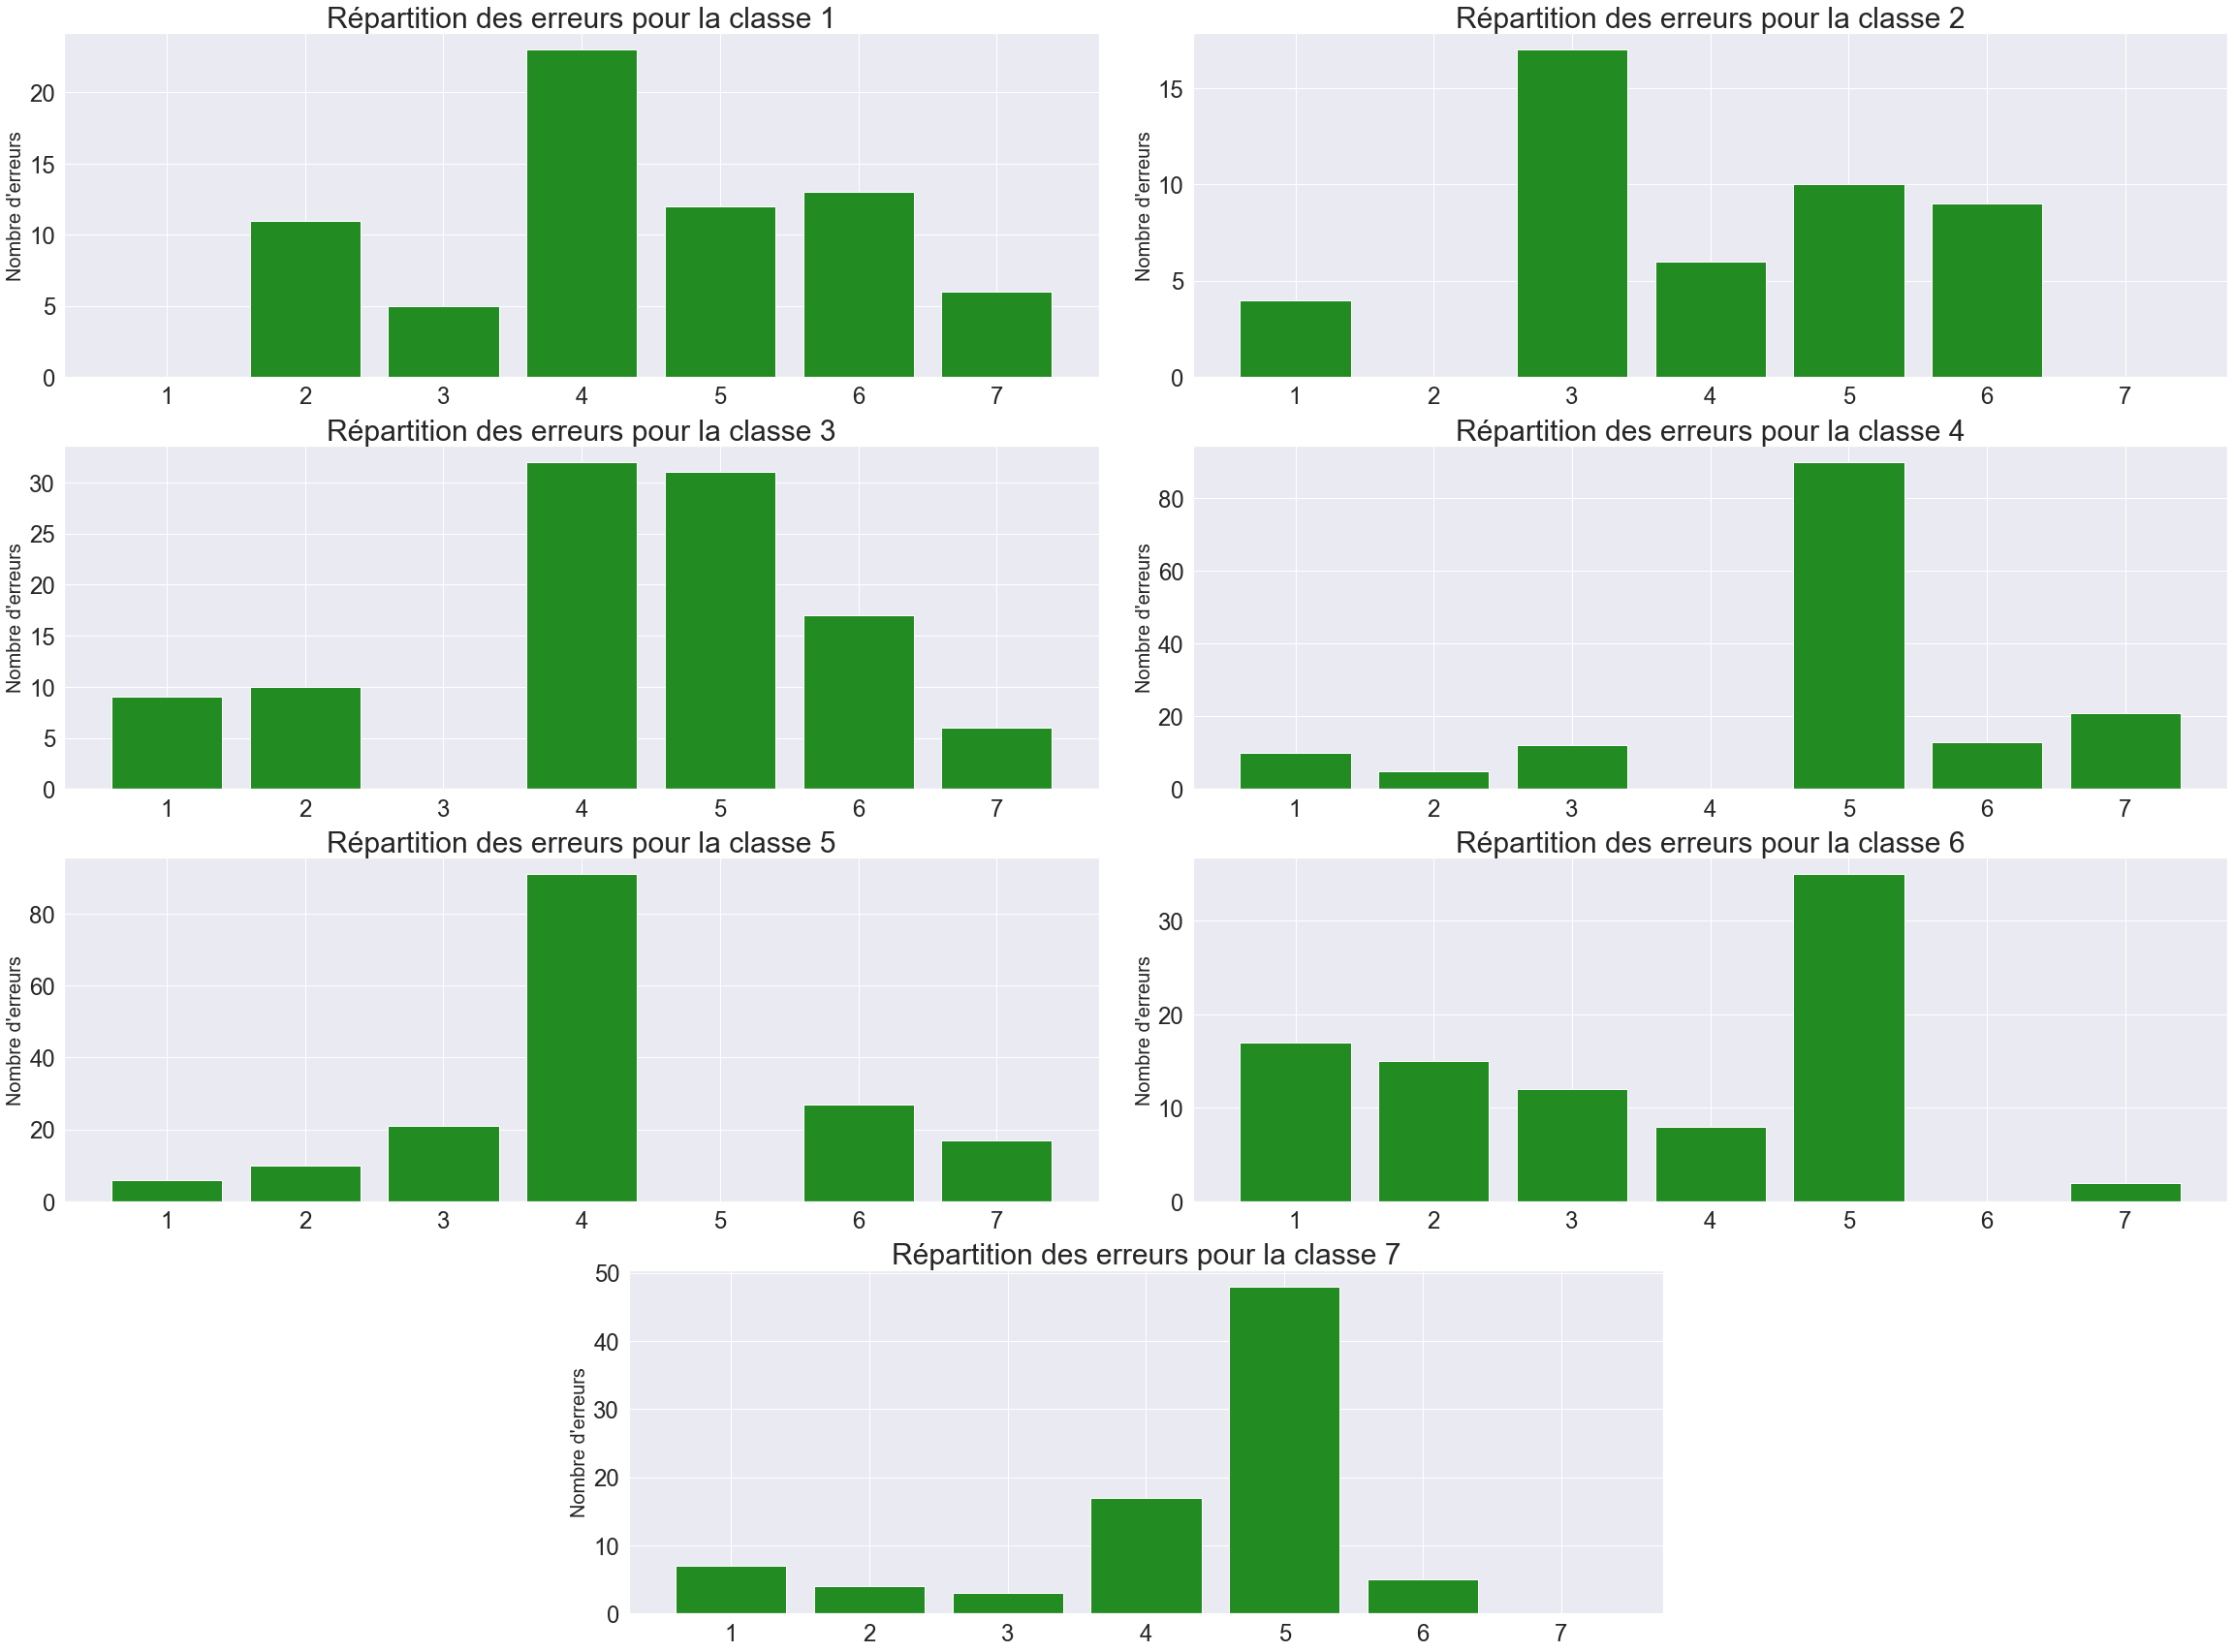

In [72]:

# Initialize the grid with 3 rows and 3 columns
ncols = 4
nrows = 4
gs = gridspec.GridSpec(4, 4)
fig = plt.figure(0,figsize=(40,30))
fig.clf()

# Add axes which can span multiple grid boxes
ax1 = plt.subplot(gs[0, 0:2])
ax2 = plt.subplot(gs[0,2:])
ax3 = plt.subplot(gs[1,0:2])
ax4 = plt.subplot(gs[1,2:])
ax5 = plt.subplot(gs[2,0:2])
ax6 = plt.subplot(gs[2,2:])
ax7 = plt.subplot(gs[3,1:3])

sns.set()

ax1.bar(L[0].keys(), L[0].values(), color='forestgreen')
ax1.set_title('Répartition des erreurs pour la classe 1',fontsize=30)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax1.set_ylabel('Nombre d\'erreurs',fontsize=20)
ax1.grid(True)
ax2.bar(L[1].keys(), L[1].values(), color='forestgreen')
ax2.set_title('Répartition des erreurs pour la classe 2',fontsize=30)
ax2.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax2.set_ylabel('Nombre d\'erreurs',fontsize=20)
ax2.grid(True)
ax3.bar(L[2].keys(), L[2].values(), color='forestgreen')
ax3.set_title('Répartition des erreurs pour la classe 3',fontsize=30)
ax3.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax3.set_ylabel('Nombre d\'erreurs',fontsize=20)
ax3.grid(True)
ax4.bar(L[3].keys(), L[3].values(), color='forestgreen')
ax4.set_title('Répartition des erreurs pour la classe 4',fontsize=30)
ax4.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax4.set_ylabel('Nombre d\'erreurs',fontsize=20)
ax4.grid(True)
ax5.bar(L[4].keys(), L[4].values(), color='forestgreen')
ax5.set_title('Répartition des erreurs pour la classe 5',fontsize=30)
ax5.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax5.set_ylabel('Nombre d\'erreurs',fontsize=20)
ax5.grid(True)
ax6.bar(L[5].keys(), L[5].values(), color='forestgreen')
ax6.set_title('Répartition des erreurs pour la classe 6',fontsize=30)
ax6.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax6.set_ylabel('Nombre d\'erreurs',fontsize=20)
ax6.grid(True)
ax7.bar(L[6].keys(), L[6].values(), color='forestgreen')
ax7.set_title('Répartition des erreurs pour la classe 7',fontsize=30)
ax7.tick_params(axis = 'both', which = 'major', labelsize = 24)
ax7.set_ylabel('Nombre d\'erreurs',fontsize=20)
ax7.grid(True)
plt.savefig("Repartition_erreur_pour_chaque_classe.pdf")

# Add labels and titles
#fig.suptitle('Figure with Subplots')
#ax1.set_ylabel('Voltage (V)')
#ax3.set_ylabel('Voltage (V)')
#ax3.set_xlabel('Time (s)')
#ax4.set_xlabel('Time (s)')

* Les classe 1,2 et 3 ne sont pas particulièrement confondues avec une autre classe en particulier.

* La classe 4 est particulièrement confondue avec la classe 5 et vice-versa.

* La classe 6 semble être confondue souvent avec la classe 5, mais il reste un bon nombre d'erreur qui sont associés a d'autre classe.

* La classe 7 est particulièrement confondue avec la classe 5 mais l'inverse est faux. 


### Mesures sur le modele

In [884]:
y_true = base_test.y_true.tolist()
y_pred = base_test.y_pred.tolist()
Y_true = [y_true[i]+1 for i in range(len(y_true))]
Y_pred = [y_pred[i]+1 for i in range(len(y_pred))]
from sklearn.metrics import classification_report
print(classification_report(Y_true,Y_pred))
plt.savefig("met.pdf")

              precision    recall  f1-score   support

           1       0.73      0.67      0.70       213
           2       0.58      0.62      0.60       120
           3       0.57      0.46      0.51       196
           4       0.67      0.70      0.68       502
           5       0.72      0.77      0.75       750
           6       0.61      0.60      0.61       223
           7       0.60      0.49      0.54       163

    accuracy                           0.67      2167
   macro avg       0.64      0.62      0.63      2167
weighted avg       0.67      0.67      0.67      2167



<Figure size 432x288 with 0 Axes>

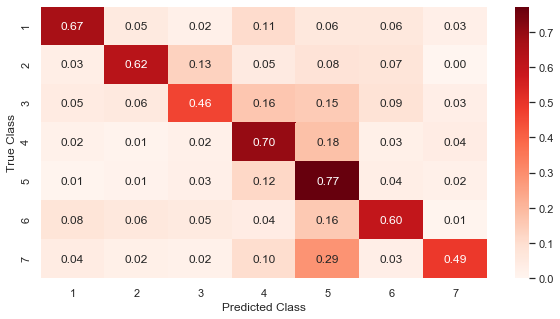

<Figure size 432x288 with 0 Axes>

In [882]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def conf_matrix(y_true, y_pred):
    C = confusion_matrix(y_true, y_pred)
        
    ConfMatrix = C / C.sum(axis=1)[:,None]
        
    plt.figure(figsize = (10, 5))
    ax = sns.heatmap(ConfMatrix, annot=True, cmap="Reds", fmt=".2f",
                xticklabels = ['1', '2', '3', '4', '5', '6', '7'], 
                yticklabels = ['1', '2', '3', '4', '5', '6', '7'])
    
    sns.set()

    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom, top)

    plt.xlabel('Predicted Class', fontsize = 12)
    plt.ylabel('True Class', fontsize = 12)
    #plt.title("Confusion Matrix", size = 14)
    plt.savefig("conf_matrix_svc.pdf")
    
    return plt.show()

conf_matrix(Y_true,Y_pred)

plt.savefig("MCBERT.pdf")

### Fine-Tuning de BERT pour deux epochs

In [22]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


import random
import numpy as np
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
total_t0 = time.time()
epochs = 2

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    t0 = time.time()
    total_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]
        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_train_loss / len(train_dataloader)    
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    print("")
    print("Running Validation...")
    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        b_input_ids = batch[0]
        b_input_mask = batch[1]
        b_labels = batch[2]
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        total_eval_loss += loss.item()
        logits = logits.detach().numpy()
        label_ids = b_labels.numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

torch.save(model.state_dict(),'model2.h5')


======== Epoch 1 / 2 ========
Training...
  Batch    50  of    610.    Elapsed: 0:13:49.
  Batch   100  of    610.    Elapsed: 0:27:08.
  Batch   150  of    610.    Elapsed: 0:40:38.
  Batch   200  of    610.    Elapsed: 0:54:07.
  Batch   250  of    610.    Elapsed: 1:08:22.
  Batch   300  of    610.    Elapsed: 1:23:12.
  Batch   350  of    610.    Elapsed: 1:37:14.
  Batch   400  of    610.    Elapsed: 1:49:27.
  Batch   450  of    610.    Elapsed: 1:57:47.
  Batch   500  of    610.    Elapsed: 2:06:36.
  Batch   550  of    610.    Elapsed: 2:14:54.
  Batch   600  of    610.    Elapsed: 2:23:31.

  Average training loss: 0.94
  Training epcoh took: 2:25:09

Running Validation...
  Accuracy: 0.67
  Validation Loss: 0.93
  Validation took: 0:04:07

======== Epoch 2 / 2 ========
Training...
  Batch    50  of    610.    Elapsed: 0:08:51.
  Batch   100  of    610.    Elapsed: 0:17:16.
  Batch   150  of    610.    Elapsed: 0:25:28.
  Batch   200  of    610.    Elapsed: 0:33:37.
  Batch  

Le résultat obtenu ne change pas